In [1]:
#data and reps from here:
#https://github.com/henanjun/LCMR/blob/1/LCMR/LCMR_demo.m

#demo for LCMR to be appeared TGRS if you use code, please kind cite the paper, "A New Spatial-Spectral Feature Extraction Method for Hyperspectral Images Using Local Covariance Matrix Representation" Leyuan Fang et al. to be appeared TGRS

import numpy as np

from itertools import compress

from hand_utils import *

import sys
sys.path.append('../scripts')
import flag_dimensionality_reduction as fdr
from utils import *


from matplotlib import pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace

import pandas as pd

INFO: Using numpy backend


In [2]:
class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


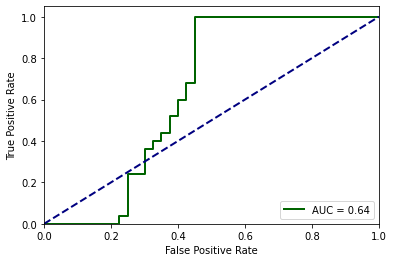

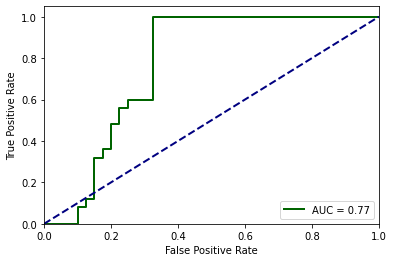

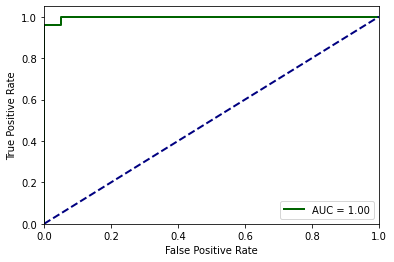

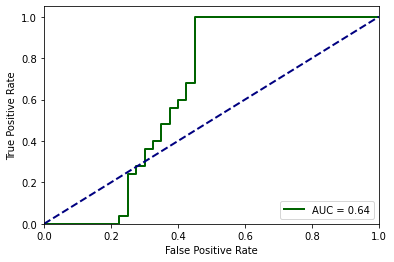

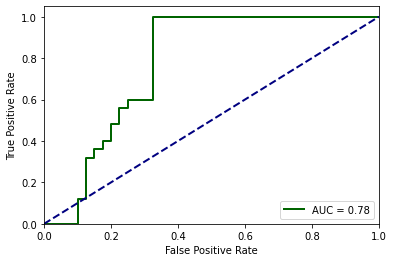

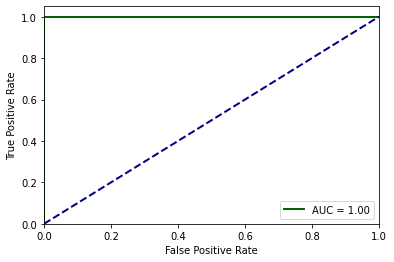

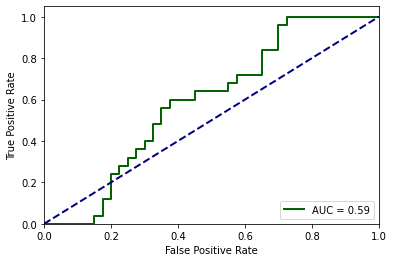

In [3]:
dr_seed = 12345

manifold = GeomstatsShapeSpace(2,56)

results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'AUC'])
fl_type = [1,2]

#33 min to run

trial = 0

for n_outs in [25]:

    # load data
    filepath = './all/shapes'
    segmentationlist = readSegmentations(filepath,getxy)[0]
    hands0 = np.array(segmentationlist).T
    hands = procrustes_hand(hands0)

    hands1 = []
    for h in hands:
        k_shape = unmake_1d(h)
        k_shape = k_shape - np.mean(k_shape, axis = 0)
        k_shape = k_shape/np.linalg.norm(k_shape)
        hands1.append(k_shape)


    x = hands1[0]

    ys = [hands1[7],hands1[9]] #works with 7

    np.random.seed(42)

    shapes = []
    for i in np.linspace(-1,1,40):
        idx = np.random.choice([0,1])
        v = manifold.log(x,ys[idx])
        inlier = manifold.exp(x, i*v)
        shapes.append(inlier)

    np.random.seed(trial)
    for i in range(n_outs):
        x= unmake_1d(hands[35])
        x = x - np.mean(x, axis = 0)
        x = x/np.linalg.norm(x)
        y = manifold.random_point()
        v = manifold.log(x,y)
        outlier = manifold.exp(x, .04*np.random.rand()*v) #.05
        shapes.append(outlier)



    labels = [0]*40 + [1]*n_outs

    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes, seed = mean_seed)

    mean = fdr.karcher_mean(manifold, shapes, seed = mean_seed)
    
    [W_w1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'wpca', return_ts = True, 
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_r1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_d1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'dpcp', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = [fl_type[-1]], pca_type = 'wpca', return_ts = True, 
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_r2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = [fl_type[-1]], pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = [fl_type[-1]], pca_type = 'dpcp', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )

    #PCA
    W_pca, _, ts_pca, mean =   PGA0( manifold, shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
        
    # dpcp_auc_val, dpcp_preds, dpcp_thresh = run_roc( shapes, W_d1ours, labels, 'dpcp', manifold, ts, median, do_plots = True )
    # row = pd.DataFrame(data = [[n_outs, 'fTDPCP(1,...,k)', dpcp_auc_val]],
    #                 columns = results.columns)
    # results = pd.concat([results, row])
    auc_val, wpca1_preds, wpca1_thresh  = run_roc( shapes, W_w1ours, labels, 'wpca', manifold, ts,     median, do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L1-WPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
    
    auc_val, rpca1_preds, rpca1_thresh  = run_roc( shapes, W_r1ours, labels, 'rpca', manifold, ts,     median, do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L1-RPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
        
    auc_val, dpcp1_preds, dpcp1_thresh  = run_roc( shapes, W_d1ours, labels, 'dpcp', manifold, ts,     median, do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L1-DPCP', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes, W_w2ours, labels, 'wpca', manifold, ts,     median, do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L2-WPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
    
    auc_val, rpca2_preds, rpca2_thresh  = run_roc( shapes, W_r2ours, labels, 'rpca', manifold, ts,     median, do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L2-RPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
        
    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc( shapes, W_d2ours, labels, 'dpcp', manifold, ts,     median,do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'L2-DPCP', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])

    
    pca_auc_val, pca_preds, pca_thresh = run_roc( shapes, W_pca,    labels, 'wpca', manifold, ts_pca, mean,   do_plots = True )
    row = pd.DataFrame(data = [[n_outs, 'TPCA', pca_auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])



In [18]:
wpca1_inlier_idx = wpca1_preds < wpca1_thresh
rpca1_inlier_idx = rpca1_preds < rpca1_thresh
dpcp1_inlier_idx = dpcp1_preds < dpcp1_thresh

wpca2_inlier_idx = wpca2_preds < wpca2_thresh
rpca2_inlier_idx = rpca2_preds < rpca2_thresh
dpcp2_inlier_idx = dpcp2_preds < dpcp2_thresh

pca_inlier_idx = pca_preds < pca_thresh


In [19]:
wpca1_thresh, rpca1_thresh, dpcp1_thresh

(0.15586612376263242, 0.44179164504244295, 0.0091236353098606)

In [20]:
wpca1_shapes = list(compress(shapes, wpca1_inlier_idx))
rpca1_shapes = list(compress(shapes, rpca1_inlier_idx))
dpcp1_shapes = list(compress(shapes, dpcp1_inlier_idx))

wpca2_shapes = list(compress(shapes, wpca2_inlier_idx))
rpca2_shapes = list(compress(shapes, rpca2_inlier_idx))
dpcp2_shapes = list(compress(shapes, dpcp2_inlier_idx))


pca_shapes = list(compress(shapes, pca_inlier_idx))

W_wpca1, _, ts_wpca1, mean_wpca1 =  PGA0( manifold, wpca1_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_rpca1, _, ts_rpca1, mean_rpca1 =  PGA0( manifold, rpca1_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_dpcp1, _, ts_dpcp1, mean_dpcp1 =  PGA0( manifold, dpcp1_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

W_wpca2, _, ts_wpca2, mean_wpca2 =  PGA0( manifold, wpca2_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_rpca2, _, ts_rpca2, mean_rpca2 =  PGA0( manifold, rpca2_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_dpcp2, _, ts_dpcp2, mean_dpcp2 =  PGA0( manifold, dpcp2_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

#PCA
W_pca, _, ts_pca, mean_pca =  PGA0( manifold, pca_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

#errors

err_wpca1, rec_data_wpca1  = reconst_err_man(manifold, mean_wpca1, wpca1_shapes, ts_wpca1, W_wpca1, return_data= True)
err_rpca1, rec_data_rpca1  = reconst_err_man(manifold, mean_rpca1, rpca1_shapes, ts_rpca1, W_rpca1, return_data= True)
err_dpcp1, rec_data_dpcp1  = reconst_err_man(manifold, mean_dpcp1, dpcp1_shapes, ts_dpcp1, W_dpcp1, return_data= True)

err_wpca2, rec_data_wpca2  = reconst_err_man(manifold, mean_wpca2, wpca2_shapes, ts_wpca2, W_wpca2, return_data= True)
err_rpca2, rec_data_rpca2  = reconst_err_man(manifold, mean_rpca2, rpca2_shapes, ts_rpca2, W_rpca2, return_data= True)
err_dpcp2, rec_data_dpcp2  = reconst_err_man(manifold, mean_dpcp2, dpcp2_shapes, ts_dpcp2, W_dpcp2, return_data= True)

err_pca, rec_data_pca  =  reconst_err_man(manifold, mean_pca, pca_shapes,  ts_pca, W_pca, return_data= True)


print('with outliers')

print('pca')
print(np.mean(err_pca))


print('wpca1')
print(np.mean(err_wpca1))
print('rpca1')
print(np.mean(err_rpca1))
print('dpcp1')
print(np.mean(err_dpcp1))

print('wpca2')
print(np.mean(err_wpca2))
print('rpca2')
print(np.mean(err_rpca2))
print('dpcp2')
print(np.mean(err_dpcp2))


with outliers
pca
0.0005873070666257449
wpca1
0.0005943860535202407
rpca1
0.0005947261503304616
dpcp1
0.009634823584822344
wpca2
0.0005943860535202407
rpca2
0.0005947261503304616
dpcp2
0.0007027458965174427


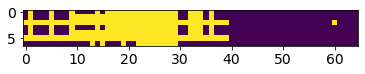

In [21]:
true_vals = np.vstack([wpca1_inlier_idx, rpca1_inlier_idx, dpcp1_inlier_idx, 
                       wpca2_inlier_idx, rpca2_inlier_idx, dpcp2_inlier_idx,
                       pca_inlier_idx])

hands_in_all_idx = np.where(np.sum(true_vals, axis = 0) > 6)[0]
plt.imshow(true_vals)

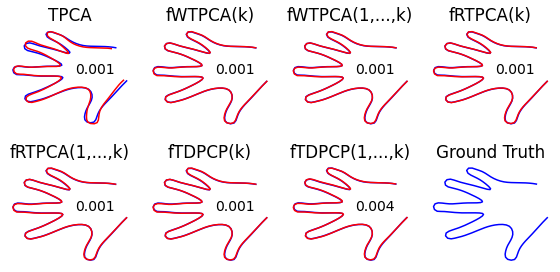

In [12]:

to_reconstr_idx = hands_in_all_idx[0]

wpca1_id = np.sum(wpca1_inlier_idx[:to_reconstr_idx])-1
rpca1_id = np.sum(rpca1_inlier_idx[:to_reconstr_idx])-1
dpcp1_id = np.sum(dpcp1_inlier_idx[:to_reconstr_idx])-1

wpca2_id = np.sum(wpca2_inlier_idx[:to_reconstr_idx])-1
rpca2_id = np.sum(rpca2_inlier_idx[:to_reconstr_idx])-1
dpcp2_id = np.sum(dpcp2_inlier_idx[:to_reconstr_idx])-1

pca_id = np.sum(pca_inlier_idx[:to_reconstr_idx])-1

recs = [ rec_data_pca, rec_data_wpca2, rec_data_wpca1, rec_data_rpca2, rec_data_rpca1, rec_data_dpcp2, rec_data_dpcp1]
labels = ['TPCA',  'fWTPCA(k)',  'fWTPCA(1,...,k)', 'fRTPCA(k)', 'fRTPCA(1,...,k)', 'fTDPCP(k)', 'fTDPCP(1,...,k)']

reconstr_ids  = [pca_id, wpca2_id, wpca1_id, rpca2_id, rpca1_id, dpcp2_id, dpcp1_id]

rec_errs = [ err_pca, err_wpca2, err_wpca1, err_rpca2, err_rpca1, err_dpcp2, err_dpcp1]
rec_errs= [np.round(er[reconstr_ids[i]],3) for i, er in zip(np.arange(len(rec_errs)), rec_errs)]


W=256
H=256


plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2,4, figsize = (8,4))

axs = axs.flatten()

for i in range(8):
 
    if i == 7:
        interp_points = interp(shapes[to_reconstr_idx])
        axs[i].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
        axs[i].set_title('Ground Truth')
        axs[i].axis('off')
    else:
        interp_points = interp(shapes[to_reconstr_idx])
        axs[i].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
        interp_points = interp(recs[i][reconstr_ids[i]])
        axs[i].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
        axs[i].text(13,-2,rec_errs[i])
        axs[i].axis('off')
        axs[i].set_title(labels[i])
        


plt.tight_layout()
plt.savefig(f'../Results/hand_qual_hand.pdf', bbox_inches = 'tight')




In [45]:
pca_id

2